In [26]:
import pandas as pd

data = pd.read_csv('NVidia_stock_history.csv')


data = data[['Date', 'Close']]

data 


,Date,Close
0,1999-01-22 00:00:00-05:00,0.037621
1,1999-01-25 00:00:00-05:00,0.041562
2,1999-01-26 00:00:00-05:00,0.038337
3,1999-01-27 00:00:00-05:00,0.038218
4,1999-01-28 00:00:00-05:00,0.038098
...,...,...
6437,2024-08-22 00:00:00-04:00,123.739998
6438,2024-08-23 00:00:00-04:00,129.369995
6439,2024-08-26 00:00:00-04:00,126.459999
6440,2024-08-27 00:00:00-04:00,128.300003


In [27]:
# Convert Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'], utc=True).dt.tz_localize(None)

# Set Date as index for time-series operations
data.set_index('Date', inplace=True)

data.head()


,Close
Date,
1999-01-22 05:00:00,0.037621
1999-01-25 05:00:00,0.041562
1999-01-26 05:00:00,0.038337
1999-01-27 05:00:00,0.038218
1999-01-28 05:00:00,0.038098


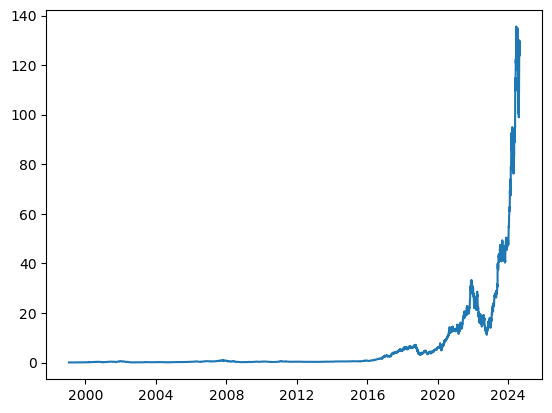

In [28]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['Close'])


In [29]:
import numpy as np

def data_to_windowed_df(data, first_date, last_date, n=3):
    # Filter data by date range
    mask = (data.index >= first_date) & (data.index <= last_date)
    filtered_data = data[mask].copy()
    
    # Extract Close prices as numpy array for easier manipulation
    close_prices = filtered_data['Close'].values
    
    # Create lists to store features (X) and targets (y)
    X = []  # Features: sequences of n days
    y = []  # Target: next day's price
    dates = []  # Dates corresponding to each target
    
    # Create sliding windows
    # For each position i, use prices[i:i+n] to predict price[i+n]
    for i in range(len(close_prices) - n):
        # Features: n consecutive days
        X.append(close_prices[i:i+n])
        # Target: the next day's price (day n+1)
        y.append(close_prices[i+n])
        # Store the date of the target
        dates.append(filtered_data.index[i+n])
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
  
    # Each column represents a day in the window (Day_0, Day_1, ..., Day_n-1)
    feature_columns = [f'Day_{i}' for i in range(n)]
    windowed_df = pd.DataFrame(X, columns=feature_columns)
    
    # Add target column
    windowed_df['Target'] = y
    
    # Add date column
    windowed_df['Date'] = dates
    
    return windowed_df

windowed_df = data_to_windowed_df(data, '1992-01-01', '2025-12-15')


In [30]:

def windowed_data_to_data_x_y(windowed_df):

    dates = windowed_df['Date'].values
    
    numeric_df = windowed_df.drop(columns=['Date'])
    df_as_np = numeric_df.to_numpy()
    
    middle_matrix = df_as_np[:, :-1] 
    x = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    
    y = df_as_np[:, -1]
    
    return dates, x.astype(np.float32), y.astype(np.float32)

dates, x, y = windowed_data_to_data_x_y(windowed_df)

dates.shape, x.shape, y.shape


((6439,), (6439, 3, 1), (6439,))

In [ ]:
# Data split: 70% training, 15% validation, 15% testing
q_70 = int(len(dates) * 0.7)   # 70% mark
q_85 = int(len(dates) * 0.85)  # 85% mark (70% + 15%)

# Training data (70%)
dates_train, x_train, y_train = dates[:q_70], x[:q_70], y[:q_70]

# Validation data (15%)
dates_val, x_val, y_val = dates[q_70:q_85], x[q_70:q_85], y[q_70:q_85]

# Testing data (15%)
dates_test, x_test, y_test = dates[q_85:], x[q_85:], y[q_85:]
